# Object Segmentation Model (U-Net Architecture)

### Detection vs. Segmentation
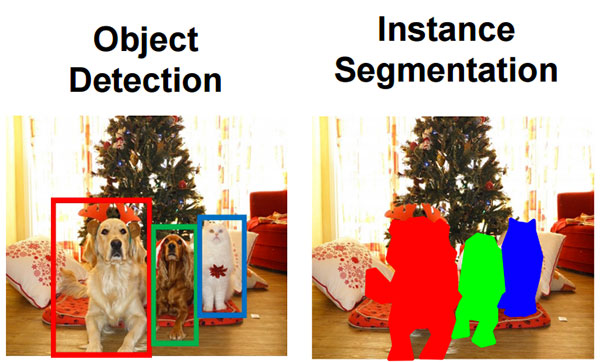

### U-Net Architecture Overview
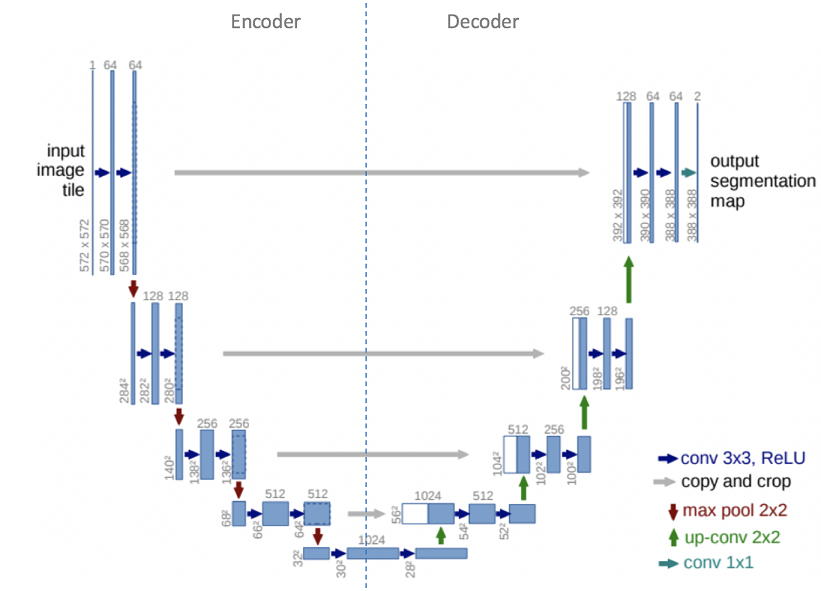

#### The U-Net model works as follows:

* The encoder is the first half in the architecture diagram (as shown above). It usually is a pre-trained classification network like VGG/ResNet where you apply convolution blocks followed by a maxpool downsampling to encode the input image into feature representations at multiple different levels.

* The decoder is the second half of the architecture. The goal is to semantically project the discriminative features (lower resolution) learnt by the encoder onto the pixel space (higher resolution) to get a dense classification. The decoder consists of upsampling and concatenation followed by regular convolution operations.

#### Importing required python libraries

Missing python libraries can be installed using the following syntax: !pip install [packagename]

In [1]:
#Importing required python libraries
import torchvision.transforms as transforms
import cv2
import numpy
import numpy as np
import os

import torchvision
import torch
import cv2
from PIL import Image
import fiftyone
import json
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import imageio as io

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torch.nn.functional as F
from torch.autograd import Variable

import albumentations as A

import time

from tqdm.notebook import tqdm

#!pip install -q segmentation-models-pytorch
#!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp


### Getting Images and Annotations

#### FIFTYONE: The open-source tool for building high-quality datasets and computer vision models.

FiftyOne provides the building blocks for optimizing your dataset analysis pipeline. Use it to get hands-on with your data, including visualizing complex labels, evaluating your models, exploring scenarios of interest, identifying failure modes, finding annotation mistakes, and much more!

#### COCO dataset can now be downloaded from FiftyOne Dataset Zoo:

Additional information can be found here: https://voxel51.com/docs/fiftyone/api/fiftyone.zoo.datasets.html

In [2]:
# Installing python libraries using 'pip' command

# !pip install fiftyone

In [3]:
# Loading and vizualising COCO dataset
# Data is usually saved in 'C:\Users\[username]\fiftyone\' directory
# Move "coco-2017" folder and place it under the project directory
# label.json has some mismatch with regards to the labels and the downloaded images. We will rectify this next.

dataset = fiftyone.zoo.load_zoo_dataset(
    "coco-2017",
    splits=("train"),
    label_types=["segmentations"],
    max_samples=20
)

# Visualize the dataset in the FiftyOne App
session = fiftyone.launch_app(dataset)

Found annotations at 'C:\Users\ambek\fiftyone\coco-2017\raw\instances_train2017.json'
 100% |████████████████████| 20/20 [1.5s elapsed, 0s remaining, 13.9 images/s]      
Writing annotations for 20 downloaded samples to 'C:\Users\ambek\fiftyone\coco-2017\train\labels.json'
Dataset info written to 'C:\Users\ambek\fiftyone\coco-2017\info.json'
Loading 'coco-2017' split 'train'
 100% |███████████████████| 20/20 [161.9ms elapsed, 0s remaining, 123.6 samples/s]     
Dataset 'coco-2017-train-20' created


#### CoCo dataset output classes:

* Coco dataset set contains the following 91 classes as output.

* Certain classes have been removed from the 2017 version of the CoCo dataset and hence the "N/A" class.

* Additional information can be found here: https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/


In [4]:
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [5]:
# Generate mask ground truth images using the annotation.json file

# Setting up the root directory for the training data
root = "coco-2017\\train\\"

# Input directory containing the annotation file
annFile = root+"labels.json"

# Loading annotation into memory using the COCO library function
coco=COCO(annFile)


# Get the category id from label.json file, here we select 'person' as a category of interest
categorySelect = ['person']
cat_ids = coco.getCatIds(catNms=categorySelect)

# Get details of all images with the specific catgory in the cat_ids variable
imgIds = coco.getImgIds(catIds=cat_ids);

allimgMetadata = coco.loadImgs(imgIds)

if len(categorySelect) > 1: 
    for i in range(len(cat_ids)):
        imgIds.append(coco.getImgIds(catIds=cat_ids[i]));
        oneCatimgId = coco.getImgIds(catIds=cat_ids[i])
        print("Total images for the Category --> "+coco_names[cat_ids[i]]+" : "+ str(len(oneCatimgId)))
    imgIds = [item for sublist in imgIds for item in sublist]
    print("Total images for all Categories --> "+coco_names[cat_ids[i]]+" : "+ str(len(imgIds)))
else:
    for i in range(len(cat_ids)):
        imgIds = coco.getImgIds(catIds=cat_ids[i]);
        print("Total images for the Category --> "+coco_names[cat_ids[i]]+" : "+ str(len(imgIds)))

loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
Total images for the Category --> person : 103


In [6]:
#Remove images from the root\data folder that do not match with the imageIds in the annotations.json file
"""
dir = root+"data\\"
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))
"""

# Download relevant training images using the imageId obtained in the above cell
# After the download is complete move all image files in "C:\Users\[username]\fiftyone\coco-2017\train\data\" to root\data
# With this, all images in the train\data folder are now consistant label in the annotation.json file

dataset = fiftyone.zoo.load_zoo_dataset(
    "coco-2017",
    splits=("train"),
    label_types=["segmentations"],
    image_ids = imgIds
    
)

Found annotations at 'C:\Users\ambek\fiftyone\coco-2017\raw\instances_train2017.json'
6 images found; downloading the remaining 97
 100% |████████████████████| 97/97 [6.2s elapsed, 0s remaining, 8.1 images/s]       
Writing annotations for 117 downloaded samples to 'C:\Users\ambek\fiftyone\coco-2017\train\labels.json'
Dataset info written to 'C:\Users\ambek\fiftyone\coco-2017\info.json'
Loading existing dataset 'coco-2017-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [12]:
# Generate mask files for all available training data

for imgMDidx in range(len(allimgMetadata)):

    oneImgMetadata = allimgMetadata[imgMDidx]
    anns_ids = coco.getAnnIds(imgIds=oneImgMetadata['id'], catIds=cat_ids, iscrowd=None)

    anns = coco.loadAnns(anns_ids)
    
    anns_img = np.zeros((oneImgMetadata['height'],oneImgMetadata['width']))
        
    
    for ann in anns:

        #anns_img = np.maximum(anns_img,coco.annToMask(ann)*ann['category_id'])
        anns_img = np.maximum(anns_img,coco.annToMask(ann)*255)

        cv2.imwrite(root+"masks\\"+oneImgMetadata["file_name"], anns_img)


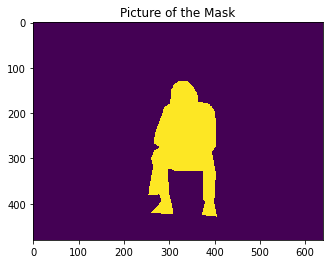

In [13]:
# Plotting the mask image
plt.imshow(anns_img, interpolation='nearest')
plt.title('Picture of the Mask')
plt.show()

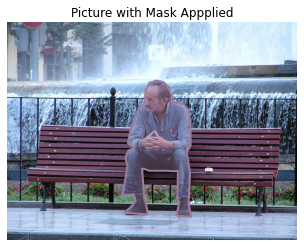

In [14]:
# Plotting the mask overlayed on an input image
I = io.imread(root+"data\\"+oneImgMetadata['file_name'])
plt.title('Picture with Mask Appplied')
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=oneImgMetadata['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

### Working with segmentation models

In [15]:
# Location of the final training data (real and mask image) is as follows:
IMAGE_PATH = root+"data\\"
MASK_PATH = root+"masks\\"


In [16]:
#Getting the image filenames and storing them in pandas dataframe for convinience


def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  103


In [17]:
#splitting the data into training, validation and testing
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  78
Val Size     :  14
Test Size    :  11


#### Setting up our CoCo dataset classes and functions.

The functions defined in the CoCoDataset() class does the following:
* Imports images that will be used in the model.
* Imports mask files (ground truth) which contain the segmentation information.
* Applies appropriate tranformations to the training set, these augmentations usually helps prevent overfitting of the model.
* Returns transformed training images along with their ground truth.

In [18]:
# Select value > 2 for multi class segmentation
n_classes = 2

class CocoDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(self.mask_path + self.X[idx] + '.jpg', cv2.IMREAD_GRAYSCALE)
        
        resizedim = (256, 256)
        img = cv2.resize(img, resizedim)
        
        mask = cv2.resize(mask, resizedim)
        
        bw_mask = np.where(mask>0, 1, mask)
        
        
        if self.transform is not None:
            aug = self.transform(image=img, bw_mask=bw_mask)
            img = Image.fromarray(aug['image'])
            bw_mask = aug['bw_mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor()])
        img = t(img)

        bw_mask = torch.from_numpy(bw_mask).long()
        
            
        return img, bw_mask
    

t_train = A.Compose([A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = CocoDataset(IMAGE_PATH, MASK_PATH, X_train, transform=None)
val_set = CocoDataset(IMAGE_PATH, MASK_PATH, X_val,transform= None)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [19]:
# Setting up unet encoder and weight parameters as required

# Additional parameter information can be found here --> https://segmentation-modelspytorch.readthedocs.io/en/latest/

model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=n_classes, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [20]:
# Defining additional functions to help with the training process

def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas
            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, CheckpointModelLoc):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, CheckpointModelLoc+'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 50:
                    print('Loss not decrease for 50 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history



### Train a U-Net Model

In [21]:
max_lr = 1e-3
epoch = 50
weight_decay = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FinalModelLoc = "model\\"
CheckpointModelLoc = "model-checkpoint\\"

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched, CheckpointModelLoc)

torch.save(model, ModelLoc+'Unet-Mobilenet.pth')

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.804 
Epoch:1/50.. Train Loss: 0.759.. Val Loss: 0.804.. Train mIoU:0.348.. Val mIoU: 0.376.. Train Acc:0.563.. Val Acc:0.576.. Time: 0.07m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.804 >> 0.746 
Epoch:2/50.. Train Loss: 0.615.. Val Loss: 0.746.. Train mIoU:0.468.. Val mIoU: 0.492.. Train Acc:0.708.. Val Acc:0.709.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.746 >> 0.590 
Epoch:3/50.. Train Loss: 0.469.. Val Loss: 0.590.. Train mIoU:0.623.. Val mIoU: 0.596.. Train Acc:0.851.. Val Acc:0.792.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.590 >> 0.416 
saving model...
Epoch:4/50.. Train Loss: 0.375.. Val Loss: 0.416.. Train mIoU:0.657.. Val mIoU: 0.647.. Train Acc:0.886.. Val Acc:0.834.. Time: 0.04m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:5/50.. Train Loss: 0.304.. Val Loss: 0.643.. Train mIoU:0.684.. Val mIoU: 0.577.. Train Acc:0.896.. Val Acc:0.802.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.643 >> 0.430 
Epoch:6/50.. Train Loss: 0.269.. Val Loss: 0.430.. Train mIoU:0.680.. Val mIoU: 0.538.. Train Acc:0.898.. Val Acc:0.800.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.430 >> 0.384 
Epoch:7/50.. Train Loss: 0.266.. Val Loss: 0.384.. Train mIoU:0.672.. Val mIoU: 0.611.. Train Acc:0.898.. Val Acc:0.834.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.384 >> 0.355 
Epoch:8/50.. Train Loss: 0.254.. Val Loss: 0.355.. Train mIoU:0.674.. Val mIoU: 0.659.. Train Acc:0.901.. Val Acc:0.842.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:9/50.. Train Loss: 0.304.. Val Loss: 0.360.. Train mIoU:0.616.. Val mIoU: 0.652.. Train Acc:0.880.. Val Acc:0.831.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.360 >> 0.355 
Epoch:10/50.. Train Loss: 0.255.. Val Loss: 0.355.. Train mIoU:0.685.. Val mIoU: 0.673.. Train Acc:0.901.. Val Acc:0.833.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:11/50.. Train Loss: 0.300.. Val Loss: 0.608.. Train mIoU:0.608.. Val mIoU: 0.537.. Train Acc:0.874.. Val Acc:0.753.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.608 >> 0.406 
saving model...
Epoch:12/50.. Train Loss: 0.277.. Val Loss: 0.406.. Train mIoU:0.624.. Val mIoU: 0.634.. Train Acc:0.883.. Val Acc:0.830.. Time: 0.04m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:13/50.. Train Loss: 0.261.. Val Loss: 0.442.. Train mIoU:0.659.. Val mIoU: 0.441.. Train Acc:0.890.. Val Acc:0.775.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.442 >> 0.410 
Epoch:14/50.. Train Loss: 0.265.. Val Loss: 0.410.. Train mIoU:0.648.. Val mIoU: 0.588.. Train Acc:0.892.. Val Acc:0.820.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.410 >> 0.381 
Epoch:15/50.. Train Loss: 0.248.. Val Loss: 0.381.. Train mIoU:0.651.. Val mIoU: 0.625.. Train Acc:0.892.. Val Acc:0.825.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.381 >> 0.330 
Epoch:16/50.. Train Loss: 0.192.. Val Loss: 0.330.. Train mIoU:0.728.. Val mIoU: 0.660.. Train Acc:0.920.. Val Acc:0.846.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:17/50.. Train Loss: 0.194.. Val Loss: 0.413.. Train mIoU:0.755.. Val mIoU: 0.590.. Train Acc:0.924.. Val Acc:0.811.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:18/50.. Train Loss: 0.230.. Val Loss: 0.417.. Train mIoU:0.694.. Val mIoU: 0.622.. Train Acc:0.904.. Val Acc:0.805.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.417 >> 0.343 
Epoch:19/50.. Train Loss: 0.189.. Val Loss: 0.343.. Train mIoU:0.743.. Val mIoU: 0.622.. Train Acc:0.924.. Val Acc:0.838.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Epoch:20/50.. Train Loss: 0.164.. Val Loss: 0.411.. Train mIoU:0.779.. Val mIoU: 0.639.. Train Acc:0.937.. Val Acc:0.819.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.411 >> 0.369 
saving model...
Epoch:21/50.. Train Loss: 0.213.. Val Loss: 0.369.. Train mIoU:0.737.. Val mIoU: 0.630.. Train Acc:0.919.. Val Acc:0.837.. Time: 0.04m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.369 >> 0.368 
Epoch:22/50.. Train Loss: 0.164.. Val Loss: 0.368.. Train mIoU:0.774.. Val mIoU: 0.646.. Train Acc:0.937.. Val Acc:0.846.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 8 time
Epoch:23/50.. Train Loss: 0.209.. Val Loss: 0.542.. Train mIoU:0.701.. Val mIoU: 0.546.. Train Acc:0.911.. Val Acc:0.756.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.542 >> 0.407 
Epoch:24/50.. Train Loss: 0.241.. Val Loss: 0.407.. Train mIoU:0.718.. Val mIoU: 0.619.. Train Acc:0.913.. Val Acc:0.835.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.407 >> 0.394 
Epoch:25/50.. Train Loss: 0.196.. Val Loss: 0.394.. Train mIoU:0.737.. Val mIoU: 0.584.. Train Acc:0.925.. Val Acc:0.786.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.394 >> 0.369 
Epoch:26/50.. Train Loss: 0.161.. Val Loss: 0.369.. Train mIoU:0.783.. Val mIoU: 0.627.. Train Acc:0.938.. Val Acc:0.822.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 9 time
Epoch:27/50.. Train Loss: 0.201.. Val Loss: 0.380.. Train mIoU:0.731.. Val mIoU: 0.557.. Train Acc:0.917.. Val Acc:0.813.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.380 >> 0.334 
saving model...
Epoch:28/50.. Train Loss: 0.129.. Val Loss: 0.334.. Train mIoU:0.813.. Val mIoU: 0.626.. Train Acc:0.950.. Val Acc:0.847.. Time: 0.04m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 10 time
Epoch:29/50.. Train Loss: 0.122.. Val Loss: 0.438.. Train mIoU:0.809.. Val mIoU: 0.606.. Train Acc:0.953.. Val Acc:0.840.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 11 time
Epoch:30/50.. Train Loss: 0.104.. Val Loss: 0.453.. Train mIoU:0.840.. Val mIoU: 0.615.. Train Acc:0.961.. Val Acc:0.834.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 12 time
Epoch:31/50.. Train Loss: 0.123.. Val Loss: 0.468.. Train mIoU:0.811.. Val mIoU: 0.606.. Train Acc:0.954.. Val Acc:0.847.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.468 >> 0.453 
Epoch:32/50.. Train Loss: 0.101.. Val Loss: 0.453.. Train mIoU:0.829.. Val mIoU: 0.608.. Train Acc:0.962.. Val Acc:0.832.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.453 >> 0.423 
Epoch:33/50.. Train Loss: 0.103.. Val Loss: 0.423.. Train mIoU:0.843.. Val mIoU: 0.634.. Train Acc:0.963.. Val Acc:0.849.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 13 time
Epoch:34/50.. Train Loss: 0.087.. Val Loss: 0.478.. Train mIoU:0.868.. Val mIoU: 0.627.. Train Acc:0.967.. Val Acc:0.842.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.478 >> 0.472 
Epoch:35/50.. Train Loss: 0.082.. Val Loss: 0.472.. Train mIoU:0.867.. Val mIoU: 0.631.. Train Acc:0.969.. Val Acc:0.842.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 14 time
Epoch:36/50.. Train Loss: 0.080.. Val Loss: 0.481.. Train mIoU:0.864.. Val mIoU: 0.628.. Train Acc:0.970.. Val Acc:0.846.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 15 time
Epoch:37/50.. Train Loss: 0.079.. Val Loss: 0.485.. Train mIoU:0.876.. Val mIoU: 0.646.. Train Acc:0.971.. Val Acc:0.845.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.485 >> 0.406 
Epoch:38/50.. Train Loss: 0.093.. Val Loss: 0.406.. Train mIoU:0.839.. Val mIoU: 0.599.. Train Acc:0.965.. Val Acc:0.837.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 16 time
Epoch:39/50.. Train Loss: 0.081.. Val Loss: 0.419.. Train mIoU:0.864.. Val mIoU: 0.637.. Train Acc:0.970.. Val Acc:0.843.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 17 time
Epoch:40/50.. Train Loss: 0.081.. Val Loss: 0.441.. Train mIoU:0.852.. Val mIoU: 0.606.. Train Acc:0.969.. Val Acc:0.827.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 18 time
Epoch:41/50.. Train Loss: 0.073.. Val Loss: 0.458.. Train mIoU:0.873.. Val mIoU: 0.601.. Train Acc:0.972.. Val Acc:0.837.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 19 time
Epoch:42/50.. Train Loss: 0.070.. Val Loss: 0.475.. Train mIoU:0.889.. Val mIoU: 0.623.. Train Acc:0.973.. Val Acc:0.842.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.475 >> 0.399 
saving model...
Epoch:43/50.. Train Loss: 0.068.. Val Loss: 0.399.. Train mIoU:0.881.. Val mIoU: 0.659.. Train Acc:0.974.. Val Acc:0.854.. Time: 0.04m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 20 time
Epoch:44/50.. Train Loss: 0.067.. Val Loss: 0.436.. Train mIoU:0.883.. Val mIoU: 0.636.. Train Acc:0.975.. Val Acc:0.848.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 21 time
Epoch:45/50.. Train Loss: 0.067.. Val Loss: 0.457.. Train mIoU:0.882.. Val mIoU: 0.617.. Train Acc:0.974.. Val Acc:0.851.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 22 time
Epoch:46/50.. Train Loss: 0.066.. Val Loss: 0.480.. Train mIoU:0.879.. Val mIoU: 0.645.. Train Acc:0.975.. Val Acc:0.840.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 23 time
Epoch:47/50.. Train Loss: 0.067.. Val Loss: 0.526.. Train mIoU:0.882.. Val mIoU: 0.594.. Train Acc:0.975.. Val Acc:0.836.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.526 >> 0.440 
Epoch:48/50.. Train Loss: 0.065.. Val Loss: 0.440.. Train mIoU:0.889.. Val mIoU: 0.605.. Train Acc:0.975.. Val Acc:0.850.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 24 time
Epoch:49/50.. Train Loss: 0.067.. Val Loss: 0.468.. Train mIoU:0.881.. Val mIoU: 0.614.. Train Acc:0.974.. Val Acc:0.838.. Time: 0.03m


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 25 time
Epoch:50/50.. Train Loss: 0.065.. Val Loss: 0.475.. Train mIoU:0.884.. Val mIoU: 0.623.. Train Acc:0.975.. Val Acc:0.848.. Time: 0.03m
Total time: 1.71 m


NameError: name 'ModelLoc' is not defined

### Testing U-Net Model

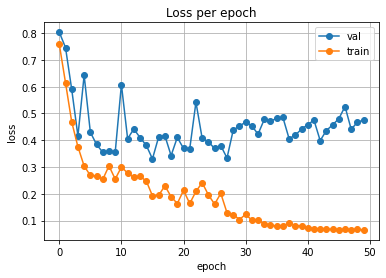

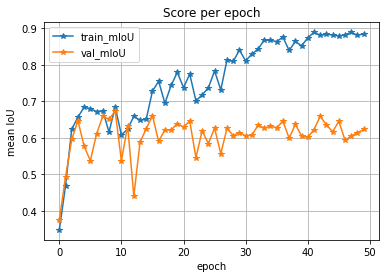

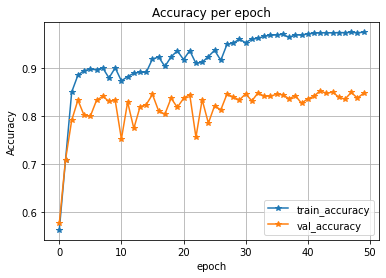

In [22]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
plot_loss(history)
plot_score(history)
plot_acc(history)

In [23]:
# Defining additional classes and functions for testing purposes

class CocoDatasetTest(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resizedim = (256, 256)
        img = cv2.resize(img, resizedim)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.jpg', cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, resizedim)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask
    
def predict_image_mask_miou(model, image, mask):
    model.eval()
    t = T.Compose([T.ToTensor()])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

def predict_image_mask_pixel(model, image, mask):
    model.eval()
    t = T.Compose([T.ToTensor()])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy


test_set = CocoDatasetTest(IMAGE_PATH, MASK_PATH, X_test)


#### Calculating the performance of the U-Net model using Intersection Over Union (IoU)

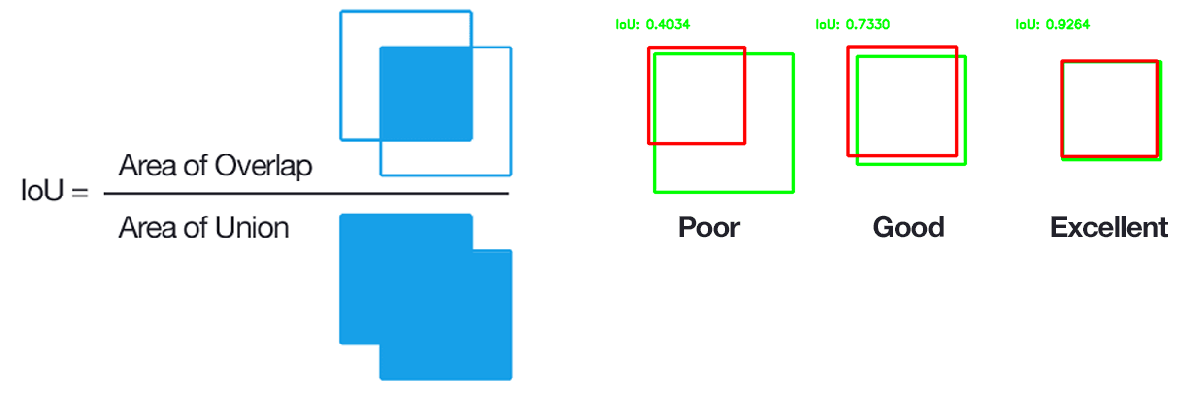

In [24]:
#Checking Intersection Over Union performance on the testing set

mob_acc = pixel_acc(model, test_set)

print("Average Accuracy on the Test Set: "+str(sum(mob_acc)/len(test_set)))


  0%|          | 0/11 [00:00<?, ?it/s]

Average Accuracy on the Test Set: 0.7723000266335227


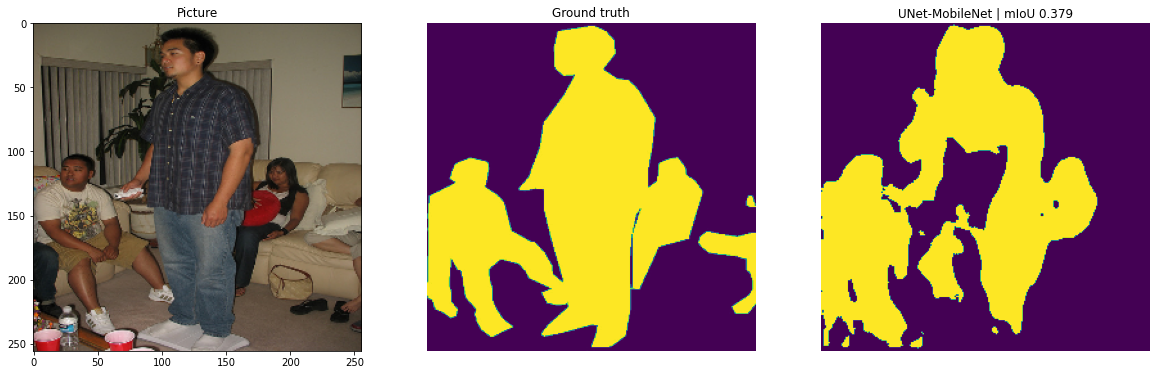

In [25]:
image2, mask2 = test_set[2]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

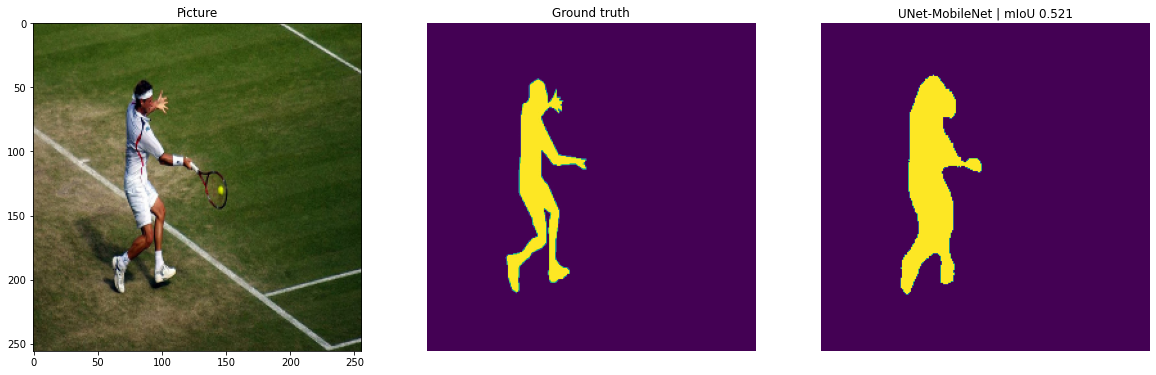

In [26]:
image2, mask2 = test_set[1]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

### References:

* https://arxiv.org/abs/1505.04597
* https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/
* https://data-flair.training/blogs/image-segmentation-machine-learning/
* https://developers.arcgis.com/python/guide/how-unet-works/
* https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
